Camembert pour les designations

- On entraine QUE sur les lignes qui ont des desc
- On sauve le modele
- On Evalue le modele
- On recharge le modele, génère les embeddings et les sauve dans un CSV

In [3]:
from RktnChallenge.RktnModel import ModelTrainer



import tensorflow as tf


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import CamembertTokenizer, TFCamembertForSequenceClassification
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import AdamW

import ast

trainer = ModelTrainer("data_tr_lemm.csv","")
nb_epochs = 20
num_categories = 27
max_features = 400
checkpoint_path = "cbert_best_desi"

def convert_and_join(str_list):
    try:
        # Convertir la chaîne en liste
        real_list = ast.literal_eval(str_list)
        # Joindre la liste pour former une chaîne
        return " ".join(real_list)
    except (ValueError, SyntaxError):
        return ""



labels = y = trainer.encodeLabel("prdtypecode")
sentences =  trainer.data["designation_tkn_lemm"].apply(convert_and_join).values.tolist()
#sentences =  trainer.data["designation_tkn_lemm"].values.tolist()

sentences_train, sentences_test, labels_train, labels_test = train_test_split(sentences, labels, test_size=0.2, random_state=42)
sentences_train, sentences_val, labels_train, labels_val = train_test_split(sentences_train, labels_train, test_size=0.1, random_state=42)



from transformers import CamembertConfig, TFCamembertModel
modelpoint = 'jplu/tf-camembert-base'
config = CamembertConfig.from_pretrained(modelpoint)
print(config)
tokenizer = CamembertTokenizer.from_pretrained(modelpoint)
model = TFCamembertForSequenceClassification.from_pretrained(modelpoint, num_labels=27)
#model = TFCamembertForSequenceClassification.from_pretrained(checkpoint_path)
#tokenizer = CamembertTokenizer.from_pretrained(checkpoint_path)


def encode_sentences(sentences, tokenizer, max_length=max_features):
    encodings = tokenizer(sentences, padding='max_length', truncation=True, max_length=max_length, return_tensors='tf')
    return {"input_ids": encodings["input_ids"], "attention_mask": encodings["attention_mask"]}
    

print("encoding sentences...")
X_train = encode_sentences(sentences_train, tokenizer)
X_val = encode_sentences(sentences_val, tokenizer)
X_test = encode_sentences(sentences_test, tokenizer)

y_train = np.array(labels_train)
y_val = np.array(labels_val)
y_test = np.array(labels_test)

from transformers import AdamWeightDecay

print("compile model...")
optimizer = AdamW(weight_decay=0.01, learning_rate=1e-5, epsilon=1e-08, clipnorm=1.0) 
#optimizer = Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0)
loss = SparseCategoricalCrossentropy(from_logits=True)

for layer in model.layers:
    layer.trainable = False
num_layers = len(model.layers)
for i in range(num_layers - 2, num_layers): 
    model.layers[i].trainable = True
    
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

early_stopper = tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy', mode='auto', patience=3, 
            verbose=1, restore_best_weights=True
        ) 

print("fit...")
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=nb_epochs, batch_size=8, callbacks=[early_stopper])
model.save_pretrained(checkpoint_path)
tokenizer.save_pretrained(checkpoint_path)


CamembertConfig {
  "architectures": [
    "CamembertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 5,
  "classifier_dropout": null,
  "eos_token_id": 6,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "camembert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.30.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 32005
}



2023-09-17 22:51:15.762853: I external/local_xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:885] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-17 22:51:15.764001: I external/local_xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:885] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-17 22:51:15.764307: I external/local_xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:885] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-17 22:51:15.765709: I external/local_xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:885] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-17 22:51:15.765996: I external/local_xla/xla

encoding sentences...
compile model...
fit...
Epoch 1/20


2023-09-17 22:51:26.272476: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
external_state_policy: POLICY_IGNORE
autotune_options {
}
warm_start: false

2023-09-17 22:51:47.870378: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fc8e42e06a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-17 22:51:47.870420: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA TITAN X (Pascal), Compute Capability 6.1
2023-09-17 22:51:47.879773: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-17 22:51:48.029231: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-09-17 22:51:48.089249: I ./tensor

7643/7643 [==============================] - ETA: 0s - loss: 1.4177 - accuracy: 0.6393

2023-09-18 00:18:56.532509: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



7643/7643 [==============================] - 5472s 712ms/step - loss: 1.4177 - accuracy: 0.6393 - val_loss: 0.8314 - val_accuracy: 0.7661
Epoch 2/20
7643/7643 [==============================] - 4367s 571ms/step - loss: 0.7184 - accuracy: 0.7931 - val_loss: 0.6342 - val_accuracy: 0.8150
Epoch 3/20
7643/7643 [==============================] - 4356s 570ms/step - loss: 0.5532 - accuracy: 0.8341 - val_loss: 0.5993 - val_accuracy: 0.8271
Epoch 4/20
7643/7643 [==============================] - 4671s 611ms/step - loss: 0.4539 - accuracy: 0.8635 - val_loss: 0.5845 - val_accuracy: 0.8404
Epoch 5/20
7643/7643 [==============================] - 4570s 598ms/step - loss: 0.3764 - accuracy: 0.8853 - val_loss: 0.5800 - val_accuracy: 0.8446
Epoch 6/20
7643/7643 [==============================] - 4575s 599ms/step - loss: 0.3128 - accuracy: 0.9038 - val_loss: 0.5911 - val_accuracy: 0.8443
Epoch 7/20
7643/7643 [==============================] - 4716s 617ms/step - loss: 0.2651 - accuracy: 0.9186 - val_loss

In [3]:
model.save_pretrained(checkpoint_path)
tokenizer.save_pretrained(checkpoint_path)

('cbert_best_desi/tokenizer_config.json',
 'cbert_best_desi/special_tokens_map.json',
 'cbert_best_desi/sentencepiece.bpe.model',
 'cbert_best_desi/added_tokens.json')

In [3]:
from RktnChallenge.RktnModel import ModelTrainer



import tensorflow as tf


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import CamembertTokenizer, TFCamembertForSequenceClassification
# Load the model
model = TFCamembertForSequenceClassification.from_pretrained(checkpoint_path)

# Load the tokenizer
tokenizer = CamembertTokenizer.from_pretrained(checkpoint_path)

All model checkpoint layers were used when initializing TFCamembertForSequenceClassification.

All the layers of TFCamembertForSequenceClassification were initialized from the model checkpoint at cbert_best_desi.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertForSequenceClassification for predictions without further training.


In [4]:
y_pred_test = model.predict(X_test)




2023-09-17 10:41:01.482017: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



531/531 [==============================] - 338s 633ms/step


weighted F1 score: 0.8646467294369357


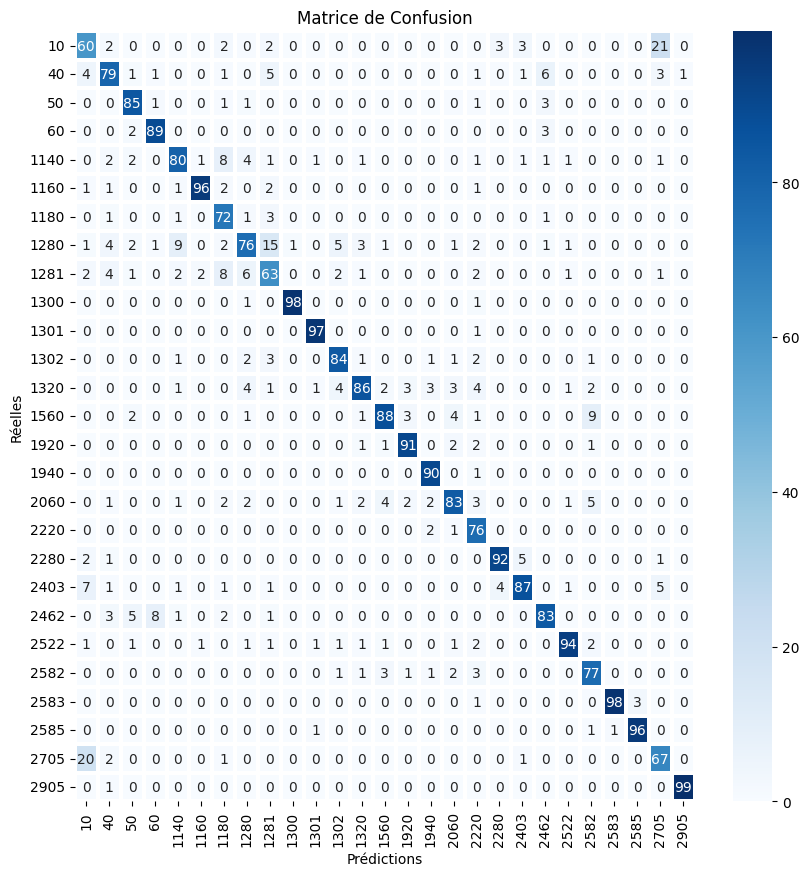

In [6]:
y_pred_out = y_pred_test.logits
y_pred = np.argmax(y_pred_out, axis=-1)

trainer.evaluateTestResults(y_test,y_pred)
#sur 250 0.86
#sur 400 0.8646467294369357

weighted F1 score: 0.8665104082352836


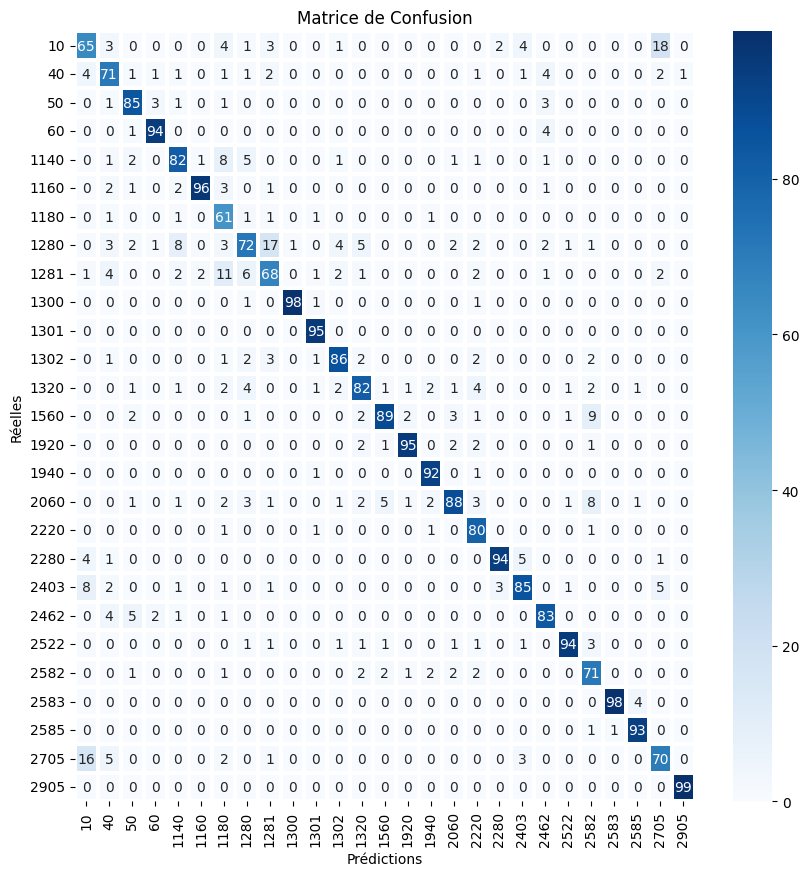

In [3]:
#lemmatisé
y_pred_out = y_pred_test.logits
y_pred = np.argmax(y_pred_out, axis=-1)

trainer.evaluateTestResults(y_test,y_pred)

weighted F1 score: 0.8343789076117947


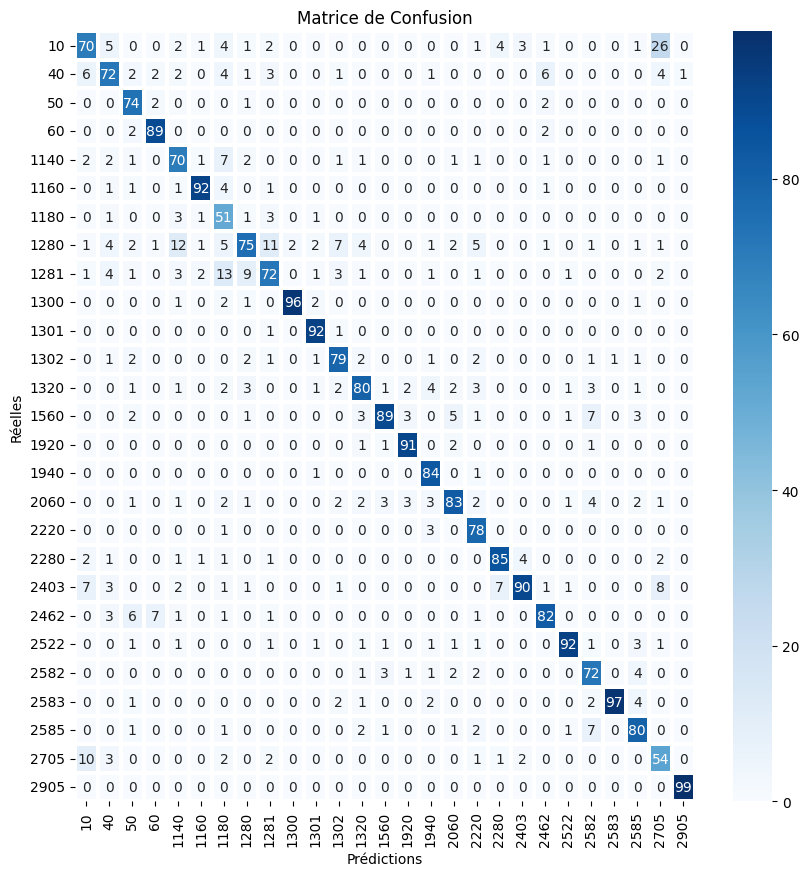

In [3]:
#non lemmatisé
y_pred_out = y_pred_test.logits
y_pred = np.argmax(y_pred_out, axis=-1)

trainer.evaluateTestResults(y_test,y_pred)

In [5]:
from RktnChallenge.RktnModel import ModelTrainer



import tensorflow as tf


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import CamembertTokenizer, TFCamembertForSequenceClassification
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import AdamW

import ast

trainer = ModelTrainer("data_tr_lemm.csv","")
nb_epochs = 10
num_categories = 27
max_features = 250
checkpoint_path = "cbert_best_desi"

def convert_and_join(str_list):
    try:
        # Convertir la chaîne en liste
        real_list = ast.literal_eval(str_list)
        # Joindre la liste pour former une chaîne
        return " ".join(real_list)
    except (ValueError, SyntaxError):
        return ""



sentences =  trainer.data["tr_designation"].apply(convert_and_join).values.tolist()

from transformers import CamembertConfig, TFCamembertModel

config = CamembertConfig.from_pretrained(checkpoint_path)
config.num_labels = 27
tokenizer = CamembertTokenizer.from_pretrained(checkpoint_path)
model = TFCamembertModel.from_pretrained(checkpoint_path, config=config)


for layer in model.layers:
    layer.trainable = False


Some layers from the model checkpoint at cbert_best_desi were not used when initializing TFCamembertModel: ['classifier']
- This IS expected if you are initializing TFCamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFCamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFCamembertModel were not initialized from the model checkpoint at cbert_best_desi and are newly initialized: ['roberta/pooler/dense/bias:0', 'roberta/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
from tqdm import tqdm

def sentence_to_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors="tf", truncation=True,  max_length=max_features)
    outputs = model(inputs.input_ids)
    embeddings = outputs.last_hidden_state
    
    embeddings = tf.reduce_mean(embeddings, axis=1)    
    return embeddings.numpy()

df = pd.read_csv("data_tr_lemm.csv")

# embeddings pour chaque texte
df['embeddings_desi'] = [sentence_to_embedding(text) for text in tqdm(sentences)]

df.to_csv("embeddings.csv", index=False)


100%|██████████| 84916/84916 [3:23:20<00:00,  6.96it/s]  
